<a href="https://colab.research.google.com/github/alracey/level4-project/blob/main/piecewise_linear_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.8.0+cu126'

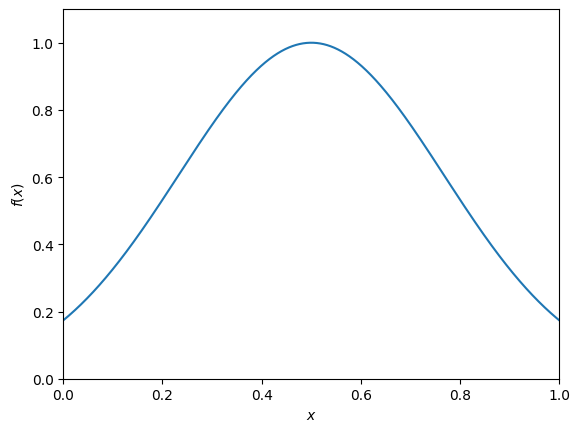

In [2]:
def f(x):
  return torch.exp(-7*(x-0.5)**2)

xs = torch.linspace(0, 1, 10000)
f_evals = f(xs)
plt.plot(xs, f_evals)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.show()

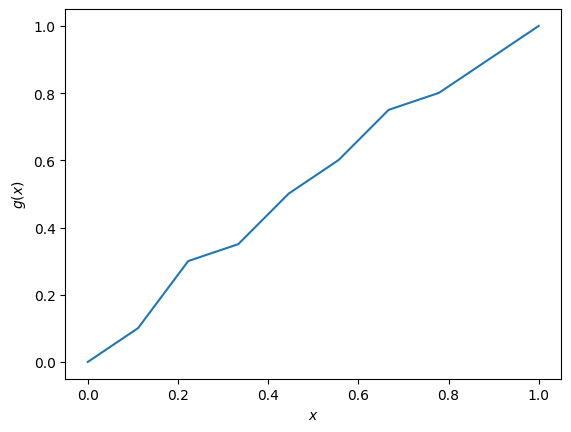

In [3]:
def g(x, y_params):   #piecewise linear transform with K bins

  #bins
  K = len(y_params) + 1

  #using given params, append 0 and 1 to the ends
  x_bins = torch.linspace(0, 1, K+1)
  ys = torch.cat([torch.tensor([0.0]), y_params, torch.tensor([1.0])])

  #find the correct bin indices i for each x value
  i_values = torch.clamp((x * K).long(), max=K-1)

  #compute the edges
  x_left = x_bins[i_values]
  x_right = x_bins[i_values+1]
  y_left = ys[i_values]
  y_right = ys[i_values+1]

  #compute the linear mappings for all x

  return y_left + ((y_right - y_left) / (x_right - x_left)) * (x - x_left)

#test plot
test_params = torch.tensor([0.1, 0.3, 0.35, 0.5, 0.6, 0.75, 0.8, 0.9])
test_g = g(xs, test_params)
plt.plot(xs, test_g)
plt.xlabel('$x$')
plt.ylabel('$g(x)$')
plt.show()

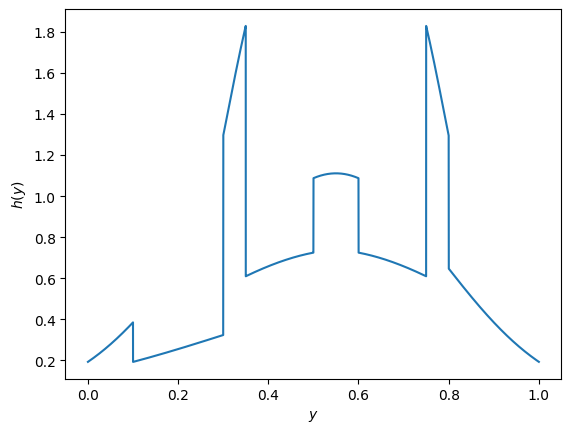

In [4]:
def h(y, y_params):   #transformed function in accordance with change of variables formula

  #bins
  K = len(y_params) + 1

  #using given params, append 0 and 1 to the ends
  x_bins = torch.linspace(0, 1, K+1)
  ys = torch.cat([torch.tensor([0.0]), y_params, torch.tensor([1.0])])

  #find the correct indices
  j_values = torch.clamp((torch.searchsorted(ys, y) - 1), 0, K-1)

  #compute the edges
  x_left = x_bins[j_values]
  x_right = x_bins[j_values+1]
  y_left = ys[j_values]
  y_right = ys[j_values+1]

  def g_inv(y):

    return x_left + ((x_right - x_left) / (y_right - y_left)) * (y - y_left)

  def jacobians(x_left, x_right, y_left, y_right):

    return (x_right - x_left) / (y_right - y_left)

  arg = g_inv(y)
  jac = jacobians(x_left, x_right, y_left, y_right)

  return f(arg) * jac

#test plot
y_test = torch.linspace(1e-10, 1, 10000)
test_h = h(y_test, test_params)
plt.plot(y_test, test_h)
plt.xlabel('$y$')
plt.ylabel('$h(y)$')
plt.show()

In [5]:
#check integral is preserved
from scipy.integrate import quad, trapezoid

x_int_test, y_int_test = torch.linspace(0, 1, 10000), torch.linspace(0, 1, 1000000)

F_numpy = trapezoid(f(x_int_test).numpy(), x_int_test.numpy())
print("F:", F_numpy)

H_numpy = trapezoid(h(y_int_test, test_params).numpy(), y_int_test.numpy())
print("H:", H_numpy)

F: 0.62881213
H: 0.62881196


In [6]:
#check variances are different in general

f_var = torch.var(f(x_int_test))
h_var = torch.var(h(y_int_test, test_params))

print("F variance:", f_var)
print("H variance:", h_var)

F variance: tensor(0.0745)
H variance: tensor(0.1690)


In [16]:
K = 32   #number of bins

#unconstrained parameters
import torch.nn.functional
def u_to_y(u):
  w = torch.nn.functional.softmax(u, dim=0)
  ys = torch.cumsum(w, dim=0)
  return ys[:-1]

u_params = torch.zeros(K-1, requires_grad=True)


In [17]:
#optimisation

#can use a training loop, variance is the loss function

x = torch.rand(10000)
optimiser = torch.optim.Adam([u_params], lr=0.01)
epochs = 200

for epoch in range(epochs):
  y_params = u_to_y(u_params)
  y = g(x, y_params)
  h_eval = h(y, y_params)

  loss = torch.var(h_eval)

  optimiser.zero_grad()

  loss.backward()

  optimiser.step()

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss}")

Epoch: 0 | Loss: 0.0736999437212944
Epoch: 10 | Loss: 0.049172189086675644
Epoch: 20 | Loss: 0.03365432843565941
Epoch: 30 | Loss: 0.02346876636147499
Epoch: 40 | Loss: 0.016466420143842697
Epoch: 50 | Loss: 0.011458841152489185
Epoch: 60 | Loss: 0.007808636873960495
Epoch: 70 | Loss: 0.005161924287676811
Epoch: 80 | Loss: 0.0032919952645897865
Epoch: 90 | Loss: 0.002036190591752529
Epoch: 100 | Loss: 0.0012591979466378689
Epoch: 110 | Loss: 0.0008335746242664754
Epoch: 120 | Loss: 0.0006376413512043655
Epoch: 130 | Loss: 0.0005669074016623199
Epoch: 140 | Loss: 0.0005491124466061592
Epoch: 150 | Loss: 0.0005468484596349299
Epoch: 160 | Loss: 0.0005468755844049156
Epoch: 170 | Loss: 0.0005466856528073549
Epoch: 180 | Loss: 0.0005464373389258981
Epoch: 190 | Loss: 0.0005463113775476813
